In [1]:
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
LARGE_FIG_SIZE=(15, 15)

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from utils import utils

In [3]:
titanic = pd.read_csv('train.csv')
utils.nan_info(titanic)

,count,percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


Survived    - Target variable

Numerical Columns

- Pclass      - useful (onehotencoder?)
- Age         - useful (has nulls, replace with medians?)
- SibSp       - useful?
- Parch       - useful?
- Fare        - useful


other columns

- Sex      - useful (ordinal encoder)
- Embarked - useful? (onehotencoder) (has 2 nulls - drop these rows)



not useful columns

- PassengerId - not useful
- Ticket   - not useful
- Cabin    - not useful
- Name     - not useful

New Features
- FamSize = SibSp + Parch
- Title

I want a simple way to compare
    - adding and removing features
    - different models
    - different hyperparameters (before and after tuning)
    
    
one function to prepare data
one function to list metrics(accuracy, precision. recall, f1_score), visualizations (conf_mx, learning curves) in an accessible way, given data and model

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer

In [5]:
titanic_test = pd.read_csv('test.csv')

In [6]:
titanic_non_null = titanic.dropna(subset=['Embarked'])
titanic_ft = titanic_non_null.drop('Survived', 1)
# titanic_labels = titanic_non_null[['Survived']]
# y = titanic_labels.values

In [146]:
titanic_combined_ft = pd.concat([titanic_ft,titanic_test], join='outer')

In [147]:
from sklearn.base import BaseEstimator, TransformerMixin

class FamilyNameExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, col_idx=0):
        self.col_idx = col_idx
    def fit(self, *args, **kwargs):
        return self
    def transform(self, X):
        res = np.array([n.split(',')[0].lower().strip() for n in X.values.ravel()])
        return res.reshape(-1,1)
    
# FamilyNameExtractor().fit_transform(titanic_non_null['Name'])

In [152]:
# embarked_encoder = OneHotEncoder()
# embarked_encoder.fit_transform(titanic_ft[['Embarked']])
# embarked_encoder.categories_


pclass_encoder = OneHotEncoder()
pclass_encoder.fit_transform(titanic_ft[['Pclass']])
pclass_encoder.categories_

family_name_pipeline = Pipeline([
    ('family_name_extractor', FamilyNameExtractor()),
    ('family_name_encoder', OneHotEncoder())
])

family_name_pipeline.fit(titanic_combined_ft[['Name']])


drop_attr = ['PassengerId', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch']
num_attr = ['Age', 'Fare'] #2
cat_ordinal_attr = ['Sex'] #1
cat_onehot_attr = ['Pclass'] # 3+665 = 6, total 10 columns



cat_pipeline = ColumnTransformer([
    ('cat_ordinal', OrdinalEncoder(), cat_ordinal_attr),
    ('cat_onehot', OneHotEncoder(), cat_onehot_attr),
    ('family_name', family_name_pipeline, ['Name']),
    ('drop_cols', 'drop', drop_attr)
], remainder='passthrough')

pipeline = Pipeline([
    ('cat_pipeline', cat_pipeline),
    ('dense_transformer', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('imputer', KNNImputer()),
    ('std_scaler', StandardScaler())
])


prepared_columns = cat_ordinal_attr \
    + ['Class-'+str(c) for c in pclass_encoder.categories_[0]] \
    + ['Family-'+str(n) for n in family_name_pipeline.named_steps['family_name_encoder'].categories_[0]] \
    + num_attr



In [149]:
from sklearn import set_config
set_config(display='diagram')
pipeline
# from sklearn import __version__
# __version__

Pipeline(steps=[('cat_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_ordinal',
                                                  OrdinalEncoder(), ['Sex']),
                                                 ('cat_onehot', OneHotEncoder(),
                                                  ['Pclass']),
                                                 ('family_name',
                                                  Pipeline(steps=[('family_name_extractor',
                                                                   FamilyNameExtractor()),
                                                                  ('family_name_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Name']),
                                                 ('drop_cols', 'drop',
                                                  ['PassengerId', 'Ticket',
                                                   'Cabin', 'Embarked', 'SibSp',
                                                   'Parch'])])),
                ('dense_transformer',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x1289e4e50>)),
                ('imputer', KNNImputer()), ('std_scaler', StandardScaler())])

In [153]:
df = pipeline.fit_transform(titanic_combined_ft)
X =df[:titanic_non_null.shape[0]]
X_test = df[titanic_non_null.shape[0]:]
y = titanic_non_null[['Survived']].values

print(X.shape, y.shape, X_test.shape)

(889, 879) (889, 1) (418, 879)


In [154]:
# X = pipeline.fit_transform(titanic_ft)
titanic_prepared = pd.DataFrame(X, columns=prepared_columns)
titanic_prep_comb = titanic_prepared.copy()
titanic_prep_comb['Survived'] = titanic_labels.values

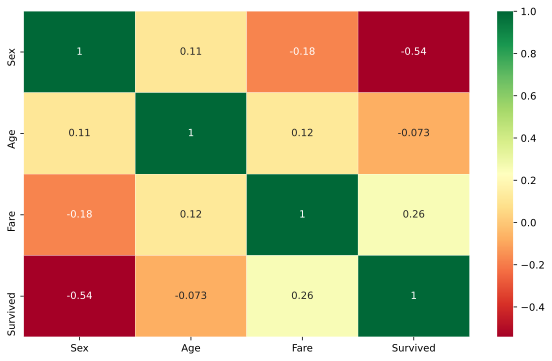

In [155]:
utils.show_corr_mx(titanic_prep_comb.loc[:,['Sex', 'Age', 'Fare', 'Survived']], (10,6))

In [90]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score


def classification_metrics(clf, X, y, prepared_columns, plot_learning_curves=True, plot_precision_recall_vs_threshold_curve=False, show_scores=True, show_feature_importances=True):
    print('score(accuracy) on training set', clf.score(X,y))

    if plot_precision_recall_vs_threshold_curve:
        y_cv_predict_proba = cross_val_predict(clf, X, y.ravel(), cv=5, method='predict_proba', n_jobs=-1)
        precisions, recalls, thresholds = precision_recall_curve(y.ravel(), y_cv_predict_proba[:,1])
        utils.plot_precision_recall_vs_threshold_curve(precisions, recalls, thresholds)

    if show_scores:
        y_cv_pred = cross_val_predict(clf, X, y.ravel(), cv=5, n_jobs=-1)
        utils.show_scores(y.ravel(), y_cv_pred)
    
    if show_feature_importances:
        utils.show_feature_importances(clf, prepared_columns)
    
    if plot_learning_curves:
        utils.plot_learning_curves(clf, X, y.ravel(), accuracy_score)

## Random Forest Classifier

In [103]:
['sqrt', 'log2'] + list(np.linspace(0.1,1,10))
0.4*len(prepared_columns)
# list(range(8,40,4))

268.40000000000003

{'bootstrap': True, 'max_depth': 12, 'max_features': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

In [159]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
     'n_estimators': [100], #100
     'max_features': [0.4,0.5,0.6,0.7], 
     'max_depth': [26,30,34], 
#      'criterion': ["gini", "entropy"], #gini
     'min_samples_split': [2],      
     'min_samples_leaf': [2],
#      'bootstrap': [True, False] #True
    },
]

clf = RandomForestClassifier(n_jobs=-1)

model_rfc = GridSearchCV(clf, param_grid, cv=3, return_train_score=True, n_jobs=-1, verbose=1)
model_rfc.fit(X, y.ravel())
print(model_rfc.best_params_, max(model_rfc.cv_results_["mean_test_score"]))
cvres = model_rfc.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    4.1s finished


{'max_depth': 30, 'max_features': 0.6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100} 0.8324347074347075


score(accuracy) on training set 0.9100112485939258
scores

precision 0.8145695364238411
recall    0.7235294117647059
f1        0.7663551401869159
accuracy  0.8312710911136107


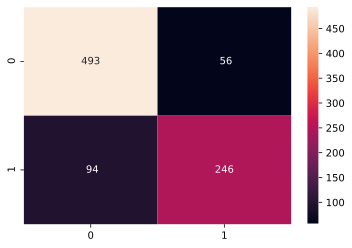

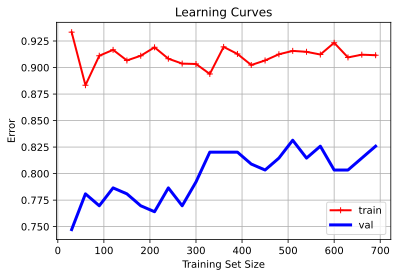

In [160]:
classification_metrics(model_rfc.best_estimator_, X, y, prepared_columns=prepared_columns, show_feature_importances=False)

Overfitting - accuracy on training set is above desired performance and accuracy on cv set is below that

In [110]:
sorted(zip(grid_search.best_estimator_.feature_importances_, prepared_columns), reverse=True)

[(0.4241444123126256, 'Sex'),
 (0.1976805701955667, 'Fare'),
 (0.18562455956579318, 'Age'),
 (0.08567462614636662, 'Class-3'),
 (0.0436826276121515, 'Class-1'),
 (0.011874979041260813, 'Class-2'),
 (0.008540890709576856, 'Family-moubarek'),
 (0.0038903129146197132, 'Family-palsson'),
 (0.003118392863071611, 'Family-asplund'),
 (0.00267583230335816, 'Family-baclini'),
 (0.0026398792119339213, 'Family-andersson'),
 (0.002558384592550487, 'Family-coutts'),
 (0.0023544774550170303, 'Family-sage'),
 (0.002056893593838179, 'Family-zabour'),
 (0.0018850049377353067, 'Family-navratil'),
 (0.0018261565163944229, 'Family-jussila'),
 (0.0017790718530555929, 'Family-richards'),
 (0.0016797361748247957, 'Family-harris'),
 (0.0012298485253986265, 'Family-boulos'),
 (0.001147875032976609, 'Family-skoog'),
 (0.00099377291835407, 'Family-kelly'),
 (0.0007937372653154649, 'Family-barbara'),
 (0.0007686498189357978, 'Family-strom'),
 (0.0007607932904975504, 'Family-daly'),
 (0.0006976496018774653, 'Famil

scores

precision 0.8870431893687708
recall    0.7852941176470588
f1        0.8330733229329174
accuracy  0.8796400449943758


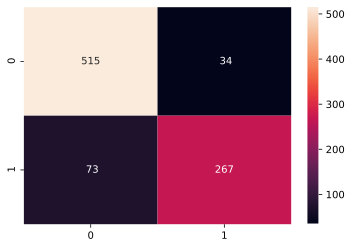

In [262]:
y_pred = grid_search.best_estimator_.predict(X)
y_predict_proba = grid_search.best_estimator_.predict_proba(X)
utils.show_scores(y.ravel(), y_pred)

In [263]:
false_negatives = (y.ravel()==1) & (y_pred==0)

false_negatives.shape
utils.nan_info(titanic_ft.loc[false_negatives])
df = titanic_ft.loc[false_negatives].copy()

df['proba'] = y_predict_proba[false_negatives][:,0]*100
df[df['proba']>75].sort_values(by='proba')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,proba
553,554,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,75.334455
207,208,3,"Albimona, Mr. Nassef Cassem",male,26.0,0,0,2699,18.7875,NaN,C,75.415875
127,128,3,"Madsen, Mr. Fridtjof Arne",male,24.0,0,0,C 17369,7.1417,NaN,S,76.600494
288,289,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S,76.942631
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S,77.222568
36,37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C,78.472213
455,456,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C,78.531761
97,98,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C,79.044415
570,571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S,79.996739
220,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,80.262750


In [142]:
false_positives = (y.ravel()==0) & (y_pred==1)
utils.nan_info(titanic_ft.loc[false_positives])
df = titanic_ft.loc[false_positives].copy()

df['proba'] = y_predict_proba[false_positives][:,1]*100
df.sort_values(by='proba')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,proba
680,681,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q,50.406572
657,658,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.5000,NaN,Q,50.487281
671,672,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S,50.841920
235,236,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.5500,NaN,S,51.785780
816,817,3,"Heininen, Miss. Wendla Maria",female,23.0,0,0,STON/O2. 3101290,7.9250,NaN,S,52.085361
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S,53.020782
38,39,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S,53.805930
698,699,1,"Thayer, Mr. John Borland",male,49.0,1,1,17421,110.8833,C68,C,54.594746
14,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S,55.464656
452,453,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C,55.526156


## SGDClassifier

In [111]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(n_jobs=-1)
sgd_clf.fit(X, y.ravel())

SGDClassifier(n_jobs=-1)

score(accuracy) on training set 0.9775028121484814
scores

precision 0.7422360248447205
recall    0.7029411764705882
f1        0.7220543806646526
accuracy  0.7930258717660292


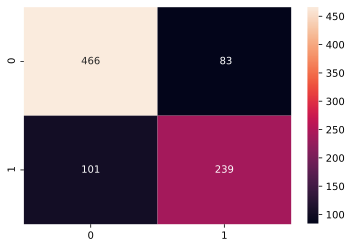

In [113]:
classification_metrics(sgd_clf, X, y, prepared_columns=prepared_columns, show_feature_importances=False, plot_learning_curves=False)

accuracy on training set and validation set. both are low -> underfitting

## KNeighborsClassifier

In [283]:
import importlib
importlib.reload(utils)

<module 'utils.utils' from '../utils/utils.py'>

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [
    {'n_neighbors': range(1,31,2), 
     'weights': ['uniform','distance'], 
     'algorithm': ['auto'], 
     'p': [1,2],
     'leaf_size': list(range(1,10,2))},
]

knn_clf = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, return_train_score=True, n_jobs=-1, verbose=1)
grid_search.fit(X, y.ravel())
print(grid_search.best_params_, max(grid_search.cv_results_["mean_test_score"]))
cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  8.4min


{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} 0.7244651812353202


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  9.2min finished


score(accuracy) on training set 0.9988751406074241
scores

precision 0.6862745098039216
recall    0.5147058823529411
f1        0.588235294117647
accuracy  0.7244094488188977


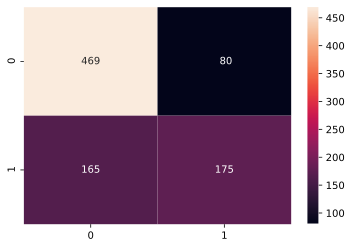

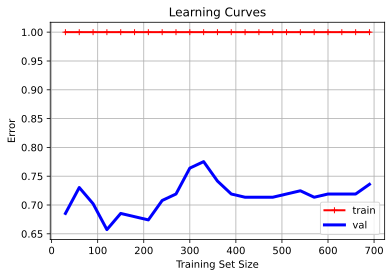

In [116]:
classification_metrics(grid_search.best_estimator_, X, y, prepared_columns=prepared_columns, show_feature_importances=False, plot_learning_curves=True)

underfitting (small) - accuarcy on training set and cv set are close to each other, however this accuracy is less than the desired performance

In [169]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

parameter_grid = {
    'base_estimator': [LogisticRegression(), SVC()],
    'n_estimators' : [10, 20, 30, 40],
}

M6 = GridSearchCV(BaggingClassifier(),
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=3,
                               n_jobs=-1,
                               verbose=1)

M6.fit(X, y.ravel())

print('Best score: ', M6.best_score_ * 100)
print('Best estimator: ', M6.best_estimator_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   37.3s finished


Best score:  78.74617041283707
Best estimator:  BaggingClassifier(base_estimator=LogisticRegression())


score(accuracy) on training set 0.9730033745781778
scores

precision 0.8062015503875969
recall    0.611764705882353
f1        0.6956521739130435
accuracy  0.7952755905511811


/Users/z00295n/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/z00295n/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

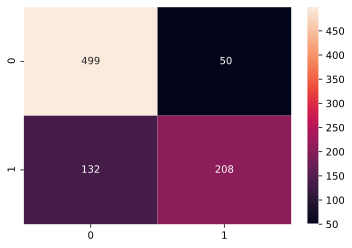

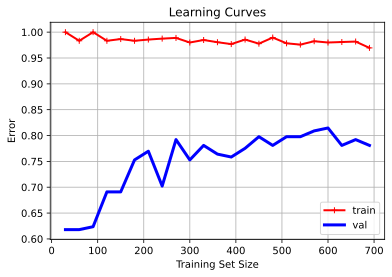

In [171]:
classification_metrics(M6.best_estimator_, X, y, prepared_columns, show_feature_importances=False, plot_learning_curves=True)

## Evaluating the Test Set

In [127]:
titanic_test = pd.read_csv('test.csv')
utils.nan_info(titanic_test)

,count,percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


In [161]:

# X_test = pipeline.transform(titanic_test)

titanic_test_prepared = pd.DataFrame(X_test, columns=prepared_columns)

# titanic_prepared_test_new = titanic_test_prepared.drop(['Embarked-C', 'Embarked-Q', 'Embarked-S'], axis=1)
# X_test_new = titanic_prepared_test_new.values

In [162]:
y_test = model_rfc.best_estimator_.predict(X_test)
result_df = pd.DataFrame(y_test, index=titanic_test['PassengerId'], columns=['Survived'])
result_df.to_csv('result_family_names_rfc.csv')

In [172]:
y_test = M6.best_estimator_.predict(X_test)
result_df = pd.DataFrame(y_test, index=titanic_test['PassengerId'], columns=['Survived'])
result_df.to_csv('result_family_names_bagging.csv')

https://www.kaggle.com/nakagawahironori/titanic-0-82-0-83
    
https://www.kaggle.com/hammaadali/titanic-easy-model-0-82-score-top-3